In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append('..')
from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from greedy_score import Greedy
from sklearn.metrics import ndcg_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
dataset_name = 'web10k'

In [100]:
exps = pickle.load( open( "./exps/{}_pointwise_exps_v1.p".format(dataset_name), "rb"))

In [101]:
#q_exps = pickle.load( open( "./exps/{}_listwise_exps.p".format(dataset_name), "rb" ) )
q_exps = pickle.load( open( "./exps/{}_listwise_exps_v1.p".format(dataset_name), "rb" ) )

In [102]:
test_sample = pickle.load( open( "./data/{}_test_sample.p".format(dataset_name), "rb" ) )

background_dict = pickle.load( open( "./data/{}_background.p".format(dataset_name), "rb" ) )

In [103]:
background = []
for q in background_dict:
    background.extend(background_dict[q])
    
background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])

In [104]:
res = {}
for q in exps.keys():
    res[q] = {}
    for p_exp in exps[q]:
        res[q][p_exp] = np.sum(np.array(exps[q][p_exp]), axis=0)
for q in res.keys():
    for e in res[q]:
        q_exps[q][e] = res[q][e]

In [105]:
queries = list(q_exps.keys())

In [106]:
exp_names = list(q_exps[queries[0]].keys())

In [107]:
ranker = lightgbm.Booster(model_file='./models/lmart_{}.txt'.format(dataset_name))
ranker.params['objective'] = 'binary'

In [108]:
ranker.num_trees()

50

In [12]:
top_k = int(0.2 * background.shape[1])

fidelity_ltr = {}
for e in exp_names:
    fidelity_ltr[e] = []
    temp = []
    for q in queries:
        doc_values = test_sample[q]
        doc_values_p = doc_values.copy()

        # perturb the doc_values based on exp
        q_exp_val = q_exps[q][e].flatten()
        #top_features =  np.argsort(np.abs(q_exp_val))[-top_k:][::-1]
        #doc_values_p[:, top_features]  =  np.mean(background[:, top_features], axis=0)

        prod = np.dot(doc_values, q_exp_val)
        output = ranker.predict(doc_values_p)
        temp.append(kendalltau(prod, output).statistic)
    fidelity_ltr[e] = np.nanmean(temp)

In [13]:
fide_ltr = pd.DataFrame(fidelity_ltr, index=['Fidelity (LTR)']).round(2)
fide_ltr

,pmi,rpi,grad,rank_lime,greedy_score,random,lime,shap,lirme,exs_v1,exs_v2,grad_d,random_d
Fidelity (LTR),-0.03,0.02,0.46,0.82,0.02,0.03,0.08,0.1,-0.11,-0.08,-0.13,0.5,0.02


In [14]:
from query_robustness import query_importance_by_perturbation_rank
grouped_data = []

for i in test_sample.keys():
    grouped_data.append(test_sample[i].copy())

q_exp_res = {}
for e in exp_names:
    q_exp_res[e] = []
    for q in queries:
        q_exp_res[e].append(q_exps[q][e])

deletion = query_importance_by_perturbation_rank(q_exp_res, grouped_data, ranker, del_type='deletion')
preservation = query_importance_by_perturbation_rank(q_exp_res, grouped_data, ranker, del_type='preservation')

robust = {'synthetic': {'deletion': deletion, 'preservation': preservation}}
pickle.dump( robust, open( "./evals/robust_{}_v1.p".format(dataset_name), "wb" ) )

pmi
rpi
grad
rank_lime
greedy_score
random
lime
shap
lirme
exs_v1
exs_v2
grad_d
random_d
pmi
rpi
grad
rank_lime
greedy_score
random
lime
shap
lirme
exs_v1
exs_v2
grad_d
random_d


In [97]:
robust = pickle.load( open( "./evals/robust_{}_v1.p".format(dataset_name), "rb" ) )

FileNotFoundError: [Errno 2] No such file or directory: './evals/robust_yahoo_v1.p'

In [15]:
def get_auc(res, robust_type):
    cutoffs = np.linspace(0.05, 0.45, 10)
    auc = {}
    dataset_names = list(res.keys())
    
    for i in range(len(dataset_names)):
        auc[dataset_names[i]] = {}
        temp_res = []
        data_name = dataset_names[i]
        res_ins = res[dataset_names[i]][robust_type]
        exp_names = list(res_ins.keys())
        for j in range(len(exp_names)):        

            temp = np.array(res_ins[exp_names[j]]).mean(axis=1)
            auc_ = 0
            for k in range(1, len(cutoffs) - 1):
                x = cutoffs[k] - cutoffs[k - 1]
                y = temp[k] + temp[k-1]
                auc_ += y / ( 2 * x)
            auc[dataset_names[i]][exp_names[j]] = auc_ 
    return auc

In [16]:
cutoff = np.linspace(0.05, 0.45, 10)

In [17]:
del_res = get_auc(robust, 'deletion')
per_res = get_auc(robust, 'preservation')

In [18]:
c_v = pd.DataFrame([del_res['synthetic'], per_res['synthetic']], index=['Completeness', 'Validity']).round(2)

In [19]:
c_v

,pmi,rpi,grad,rank_lime,greedy_score,random,lime,shap,lirme,exs_v1,exs_v2,grad_d,random_d
Completeness,42.15,0.00,25.29,11.30,17.94,13.31,35.81,39.73,11.50,11.37,10.04,27.00,12.90
Validity,0.00,40.74,6.06,14.76,14.00,16.33,1.64,0.01,19.75,20.19,22.86,6.08,15.88


In [20]:
def avg_per_cutoff(cutoff, robust_data, e):
    temp = []
    c = []
    for k in range(len(cutoff)):
        for l in range(len(robust_data[e])):
            c.append(np.abs(robust_data[e][k]))
        temp.append(np.mean(c))
    return temp

def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 18, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18, weight = 'bold', color = '0.2')

    return ax

In [21]:
import matplotlib.pyplot as plt

In [22]:
#subset_exps = ['pmi',  'rank_lime', 'greedy_score',  'lime', 'shap', 'lirme', 'exs_v1', 'exs_v2', 'random']
#exp_names_alt = np.array(['PMI',  'RankLIME', 'GreedyScore', 'LIME', 'SHAP', 'LIRME', 'EXS (TopK)', 'EXS (Score)', 'random'])

In [23]:
subset_exps = np.array(['pmi',  'greedy_score', 'rank_lime', 'lirme', 'exs_v1', 'exs_v2', 'lime', 'shap', 'random'])
subset_exps_alt = np.array(['PMI',  'Greedy Score', 'RankLIME', 'LIRME', 'EXS (Top-k)', 'EXS (Score)', 'LIME', 'SHAP', 'Random'])
colors = ['turquoise',  'red',  'blue', 'gold', 'lightgreen', 'magenta', 'darkorange', 'brown', 'black']

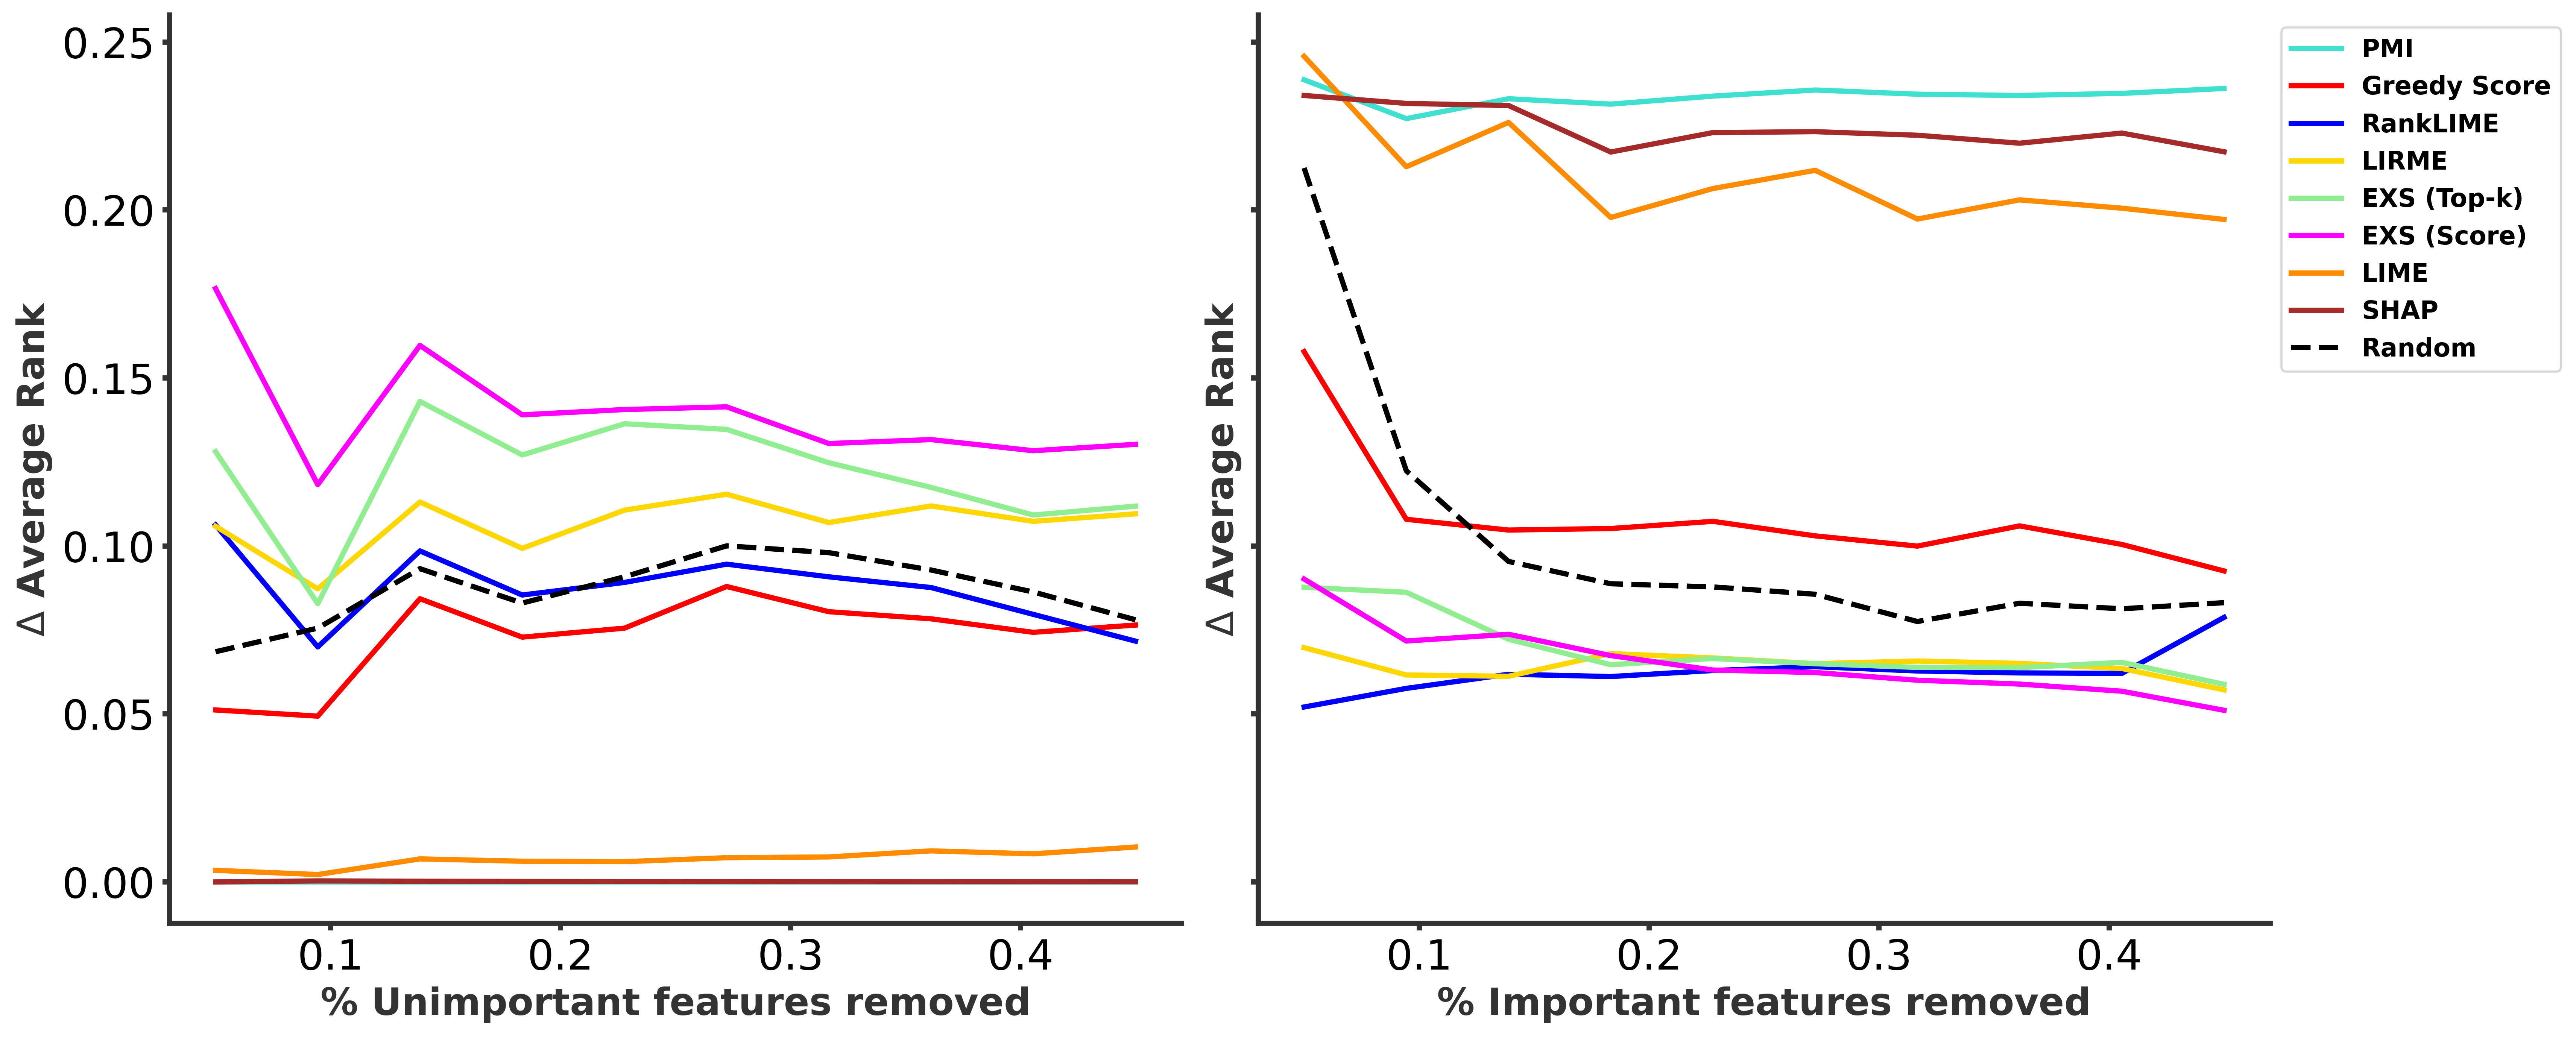

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7), sharey=True, dpi=400)

for i in range(len(subset_exps)):
    e = subset_exps[i]
    
    per = avg_per_cutoff(cutoff, robust['synthetic']['preservation'], e)
    if i == len(subset_exps) - 1:
        ax[0].plot(cutoff, per, label=subset_exps_alt[i], color=colors[i], 
                   linewidth=2.5, linestyle='dashed')
    else:
        ax[0].plot(cutoff, per, label=subset_exps_alt[i], color=colors[i], 
                   linewidth=2.5)
    ax[0].set_xlabel('% Unimportant features removed', fontsize=20)
    ax[0].set_ylabel('$\Delta$ Average Rank')
    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[0] = process_ax(ax[0])
    
    dele = avg_per_cutoff(cutoff, robust['synthetic']['deletion'], e)
    if i == len(subset_exps) - 1:
        ax[1].plot(cutoff, dele, label=subset_exps_alt[i], color=colors[i], 
                   linewidth=2.5, linestyle='dashed')
    else:
        ax[1].plot(cutoff, dele, label=subset_exps_alt[i], color=colors[i], 
                   linewidth=2.5)
    ax[1].tick_params(axis='both', which='major', labelsize=20)

    ax[1].set_xlabel('% Important features removed', fontsize=20)
    ax[1].set_ylabel('$\Delta$ Average Rank')
    ax[1] = process_ax(ax[1])

ax[1].legend(loc='upper right', prop = {'weight':'bold', 'size':12}, bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('./img/query_robustness_{}_v1.pdf'.format(dataset_name), bbox_inches='tight')

plt.show()

In [25]:
def get_dp_query(model, data, all_feat_names):
    tree_logic = model.trees_to_dataframe()
    num_estimators = model.num_trees()

    all_dec_paths = []

    for j in range(num_estimators):
        temp = []
        this_tree_decision_path = np.zeros((data.shape[0], data.shape[1]))
        
        for i in range(data.shape[0]):
            instance = data[i]
            decision_path = np.zeros(data.shape[1])
            len_decision_paths = []

            tree_idx = j
            tree_info = tree_logic[tree_logic['tree_index'] == tree_idx]
            root_node = tree_info[tree_info['parent_index'].values == None]
            node_info = root_node
            
            while (not (node_info['left_child'].values[0] == None and node_info['right_child'].values[0] == None)):
                split_feat = node_info['split_feature'].values
                
                feat_idx = np.argwhere(all_feat_names == split_feat).flatten()[0]
                
                #this_tree_decision_path[i, feat_idx] += 1 * (node_info['node_depth'].values) * (1/(node_info['weight'].values + 0.0001))
                this_tree_decision_path[i, feat_idx] += 1 
                
                if root_node['decision_type'].values == '<=': 
                    condition = instance[feat_idx] <= node_info['threshold'].values[0]
                else: 
                    condition = instance[feat_idx] > node_info['threshold'].values[0]

                if condition == False:
                    node_id = node_info['right_child'].values[0]

                    node_info = tree_logic[tree_logic['node_index'] == node_id]
                else: 
                    node_id = node_info['left_child'].values[0]

                    node_info = tree_logic[tree_logic['node_index'] == node_id]

        #all_dp_paths = np.sum(this_tree_decision_path, axis=0) / data.shape[0]
        all_dp_paths = np.sum(this_tree_decision_path, axis=0) #/ data.shape[0]
        #all_dp_paths *= evals['valid_1']['ndcg@5'][tree_idx]
        
        all_dec_paths.append(all_dp_paths)
    
    '''final_vector = []
    for path in all_dec_paths:
        if np.sum(path) != 0:
            final_vector.append(path)
    
    final_vector = np.array(final_vector)
    
    f_path = np.mean(final_vector, axis=0)'''
    all_dec_paths = np.mean(np.array(all_dec_paths), axis=0) #/ num_estimators
    
    return all_dec_paths

In [26]:
dpff = {}
for e in exp_names:
    dpff[e] = []
    temp = []
    print(e)
    for q in queries:
        doc_values = test_sample[q]
        q_exp_val = q_exps[q][e].flatten()
        dpff_val = get_dp_query(ranker, doc_values, ranker.feature_name())
        temp.append(kendalltau(dpff_val, q_exp_val).statistic)
    dpff[e] = np.nanmean(temp)
pickle.dump( dpff, open( "./evals/dpff_{}_v1.p".format(dataset_name), "wb" ) )

pmi
rpi
grad
rank_lime
greedy_score
random
lime
shap
lirme
exs_v1
exs_v2
grad_d
random_d


In [110]:
dpff = pickle.load( open( "./evals/dpff_{}_v1.p".format(dataset_name), "rb" ) )

FileNotFoundError: [Errno 2] No such file or directory: './evals/dpff_yahoo_v1.p'

In [27]:
ff = pd.DataFrame([dpff], index=['FF Similarity']).round(2)

In [28]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

In [29]:
top_k = int(0.1 * background.shape[1])

fidelity_nonltr = {}
for e in exp_names:
    fidelity_nonltr[e] = []
    temp = []
    for q in queries:
        doc_values = test_sample[q]
        doc_values_p = doc_values.copy()

        # perturb the doc_values based on exp
        q_exp_val = q_exps[q][e].flatten()
        top_features =  np.argsort(np.abs(q_exp_val))[-top_k:][::-1]
        doc_values_p[:, top_features]  =  np.mean(background[:, top_features], axis=0)

        prod = np.dot(doc_values_p, q_exp_val)
        
        output_0 = ranker.predict(doc_values)
        output_1 = ranker.predict(doc_values_p)
        output = np.abs(output_1 - output_0)
        
        temp.append(kendalltau(prod, output).statistic)
    fidelity_nonltr[e] = np.nanmean(temp)

In [30]:
fide_nonltr = pd.DataFrame(fidelity_nonltr, index=['InFidelity']).round(2)
fide_nonltr

,pmi,rpi,grad,rank_lime,greedy_score,random,lime,shap,lirme,exs_v1,exs_v2,grad_d,random_d
InFidelity,0.02,0.06,-0.06,-0.1,0.17,0.07,-0.05,-0.05,0.07,0.04,0.08,-0.16,0.04


In [31]:
## Explain NCDG@10

explain_ndcg = {}
for e in exp_names:
    explain_ndcg[e] = []
    temp = []
    for q in queries:
        doc_values = test_sample[q]
        doc_values_p = doc_values.copy()

        # perturb the doc_values based on exp
        q_exp_val = q_exps[q][e].flatten()
        #top_features =  np.argsort(np.abs(q_exp_val))[-top_k:][::-1]
        #doc_values_p[:, top_features]  =  np.mean(background[:, top_features], axis=0)

        prod = np.dot(doc_values, q_exp_val)
        
        output = min_max(ranker.predict(doc_values_p))
        
        #temp.append(kendalltau(prod, output).statistic)
        temp.append(ndcg_score([output], [prod], k=10))
    explain_ndcg[e] = np.nanmean(temp)

In [32]:
endcg = pd.DataFrame([explain_ndcg], index=['ExplainNDCG@10']).round(2)

In [33]:
total_result = pd.concat([c_v, fide_nonltr, endcg, fide_ltr,  ff])

In [34]:
#subset_exp = np.array(['pmi', 'rpi', 'grad', 'greedy_score', 'rank_lime', 'lirme', 'exs_v1', 'exs_v2', 'lime', 'shap', 'random'])

total_result = total_result.filter(subset_exps)
total_result.columns = subset_exps_alt

In [39]:
total_result.style.highlight_min(axis=1)

,PMI,Greedy Score,RankLIME,LIRME,EXS (Top-k),EXS (Score),LIME,SHAP,Random
Completeness,42.150000,17.940000,11.300000,11.500000,11.370000,10.040000,35.810000,39.730000,13.310000
Validity,0.000000,14.000000,14.760000,19.750000,20.190000,22.860000,1.640000,0.010000,16.330000
InFidelity,0.020000,0.170000,-0.100000,0.070000,0.040000,0.080000,-0.050000,-0.050000,0.070000
ExplainNDCG@10,0.450000,0.440000,0.960000,0.390000,0.420000,0.420000,0.500000,0.530000,0.490000
Fidelity (LTR),-0.030000,0.020000,0.820000,-0.110000,-0.080000,-0.130000,0.080000,0.100000,0.030000
FF Similarity,0.790000,-0.130000,0.030000,-0.010000,-0.030000,-0.010000,-0.230000,-0.080000,0.000000


In [38]:
print(total_result.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    PMI &  Greedy Score &  RankLIME &  LIRME &  EXS (Top-k) &  EXS (Score) &   LIME &   SHAP &  Random \\
\midrule
Completeness   &  42.15 &         17.94 &     11.30 &  11.50 &        11.37 &        10.04 &  35.81 &  39.73 &   13.31 \\
Validity       &   0.00 &         14.00 &     14.76 &  19.75 &        20.19 &        22.86 &   1.64 &   0.01 &   16.33 \\
InFidelity     &   0.02 &          0.17 &     -0.10 &   0.07 &         0.04 &         0.08 &  -0.05 &  -0.05 &    0.07 \\
ExplainNDCG@10 &   0.45 &          0.44 &      0.96 &   0.39 &         0.42 &         0.42 &   0.50 &   0.53 &    0.49 \\
Fidelity (LTR) &  -0.03 &          0.02 &      0.82 &  -0.11 &        -0.08 &        -0.13 &   0.08 &   0.10 &    0.03 \\
FF Similarity  &   0.79 &         -0.13 &      0.03 &  -0.01 &        -0.03 &        -0.01 &  -0.23 &  -0.08 &    0.00 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [40]:
top_ks = 0.2

top_k = int(top_ks * background.shape[1])
similarity = np.zeros((len(subset_exps) - 1, len(subset_exps) - 1))

for i in range(len(subset_exps) - 1):
    e_i = subset_exps[i]
    for j in range(i + 1):
        e_j = subset_exps[j]
        temp = []

        for k in range(len(queries)):
            first_exp = q_exps[queries[k]][e_i]
            second_exp = q_exps[queries[k]][e_j]

            ranked_first = np.argsort(np.abs(first_exp))[-top_k:][::-1]
            ranked_second = np.argsort(np.abs(second_exp))[-top_k:][::-1]

            f_exp_1 = np.zeros(background.shape[1])
            f_exp_1[ranked_first] = 1

            f_exp_2 = np.zeros(background.shape[1])
            f_exp_2[ranked_second] = 1

            temp.append(jaccard_score(f_exp_1, f_exp_2, average='binary'))

        similarity[i][j] = np.nanmean(temp)

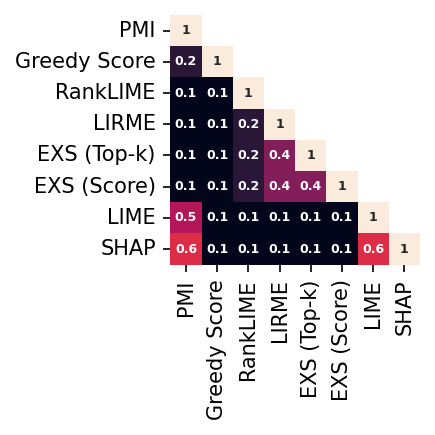

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
similarity[np.triu_indices(similarity.shape[0], +1)] = np.nan
sns.heatmap(similarity.round(1), xticklabels=subset_exps_alt[:-1], yticklabels=subset_exps_alt[:-1], 
        annot=True, annot_kws={"fontsize":6, 'fontweight':'bold'}, ax=ax, cbar=False)
plt.tight_layout()
plt.savefig('./img/pairwise_{}.pdf'.format(dataset_name))
plt.show()